# MadMiner Parton-Level Analysis for $W\gamma$: Step 2 - Analysis

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import kinematic_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge


## Define Input File sample

In [2]:
#Event Number
usenumber='100k'
nsamples=50000

#NN Settings
usename='100k_s4'
test_split=0.5

#[label,n_hidden,n_epochs,initial_lr,final_lr]
listsettings=[
     ['A1',(100,100),50,0.01,0.01],
     ['A2',(100,100),50,0.01,0.001],
     ['A3',(100,100),50,0.01,0.0001],
     ['B1',(100,100),50,0.001,0.001],
     ['B2',(100,100),50,0.001,0.0001],
     ['B3',(100,100),50,0.001,0.00001],
]
listsettings=[
     ['A',(100,100),50,0.1,0.0001],
     ['B',(100,100),50,0.01,0.0001],
     ['C',(100,100),50,0.001,0.0001],
     ['D',(100,100),50,0.0001,0.0001],
]
listsettings=[
     ['2',(100,100),50,0.001,0.0001],
     ['3',(100,100,100),50,0.001,0.0001],
     ['4',(100,100,100,100),50,0.001,0.0001],
     ['5',(100,100,100,100,100),50,0.001,0.0001]
]

#file names and directories
useinputdata = 'data/madminer_wgamma_observables_'+usenumber+'.h5'
usesamplesdir = 'data/samples_'+usename+'/'
usemodelsdir = 'models/samples_'+usename+'/'

## 6. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)
n_estimators = 2

#augment train sample
for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=nsamples,
        folder='./'+usesamplesdir,
        filename='train{}'.format(i),
        test_split=test_split
    )

#augment test sample
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
    filename='test',
    test_split=test_split
)

18:11  
18:11  ------------------------------------------------------------
18:11  |                                                          |
18:11  |  MadMiner v2018.11.02                                    |
18:11  |                                                          |
18:11  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:11  |                                                          |
18:11  ------------------------------------------------------------
18:11  
18:11  Loading data from data/madminer_wgamma_observables_100k.h5
18:11  Found 2 parameters:
18:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:11  Found 6 benchmarks:
18:11     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
18:11     w: CWL2 = 20.00, CPWL2 = 0.00e+00
18:11     morphing_basis_vector_2: CWL2 = -4.72e+01, CPWL2 = 23.25
18:11     morphing_basis_vector_3: CWL2 = 18.64, CPWL2 =

## 7. Train a neural network to estimate the score

### 7a) Change Features

In [4]:
#Run NN
for ii in range(len(listsettings)):
    thissetting=listsettings[ii]
    
    #Setup ensemble
    ensemble = EnsembleForge(estimators=n_estimators)
    #train ensemble
    ensemble.train_all(
        method='sally',
        x_filename=[usesamplesdir+'x_train{}.npy'.format(i) for i in range(n_estimators)],
        t_xz0_filename=[usesamplesdir+'t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
        validation_split=None,
        n_hidden=thissetting[1],
        n_epochs=thissetting[2],
        initial_lr=thissetting[3],
        final_lr=thissetting[4]
    )
    #save ensemble
    ensemble.save(usemodelsdir+'sally_ensemble_{}'.format(thissetting[0]))

18:11  Training 2 estimators in ensemble
18:11  Training estimator 1 / 2 in ensemble
18:11  Starting training
18:11    Method:                 sally
18:11    Training data: x at data/samples_100k_s4/x_train0.npy
18:11                   t_xz (theta0) at  data/samples_100k_s4/t_xz_train0.npy
18:11    Features:               all
18:11    Method:                 sally
18:11    Hidden layers:          (100, 100)
18:11    Activation function:    tanh
18:11    Batch size:             128
18:11    Trainer:                amsgrad
18:11    Epochs:                 50
18:11    Learning rate:          0.001 initially, decaying to 0.0001
18:11    Validation split:       None
18:11    Early stopping:         True
18:11    Scale inputs:           True
18:11  Loading training data
18:11  Found 50000 samples with 2 parameters and 23 observables
18:11  Rescaling inputs
18:11  Creating model for method sally
18:11  Training model
18:11    Epoch 5: train loss 0.00 ([0.00234672])
18:11    Epoch 10: train lo

18:16    Epoch 20: train loss 0.00 ([0.0019911])
18:16    Epoch 25: train loss 0.00 ([0.00196787])
18:16    Epoch 30: train loss 0.00 ([0.00189541])
18:16    Epoch 35: train loss 0.00 ([0.00185117])
18:16    Epoch 40: train loss 0.00 ([0.00182485])
18:16    Epoch 45: train loss 0.00 ([0.00179747])
18:17    Epoch 50: train loss 0.00 ([0.00176957])
18:17  Finished training
18:17  Training 2 estimators in ensemble
18:17  Training estimator 1 / 2 in ensemble
18:17  Starting training
18:17    Method:                 sally
18:17    Training data: x at data/samples_100k_s4/x_train0.npy
18:17                   t_xz (theta0) at  data/samples_100k_s4/t_xz_train0.npy
18:17    Features:               all
18:17    Method:                 sally
18:17    Hidden layers:          (100, 100, 100, 100, 100)
18:17    Activation function:    tanh
18:17    Batch size:             128
18:17    Trainer:                amsgrad
18:17    Epochs:                 50
18:17    Learning rate:          0.001 initially

## 8. FisherInfo for Processed Data

In [5]:
#Setup MadFisher
fisher = FisherInformation(useinputdata, debug=False)

# Setup Lists
list_mean =[]
list_error=[]
list_color=[]
list_style=[]
list_label=[]

#Run MadFisher
for ii in range(len(listsettings)):
    thissetting=listsettings[ii]
    
    fi_det_mean_all, fi_det_cov_all = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,
        model_file=usemodelsdir+'sally_ensemble_{}'.format(thissetting[0]),
        unweighted_x_sample_file=usesamplesdir+'x_test.npy'
    )
    
    list_mean  = list_mean  + [fi_det_mean_all]
    list_error = list_error + [fi_det_cov_all]
    list_color = list_color + ['C'+str(ii)]
    list_style = list_style + ["solid"]
    list_label = list_label + [thissetting[0]]

#Run MadFisher Truth
fi_pl_mean_full , _ = fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
list_mean  = list_mean  + [fi_pl_mean_full]
list_error = list_error + [None]
list_color = list_color + ["black"]
list_style = list_style + ["dashed"]
list_label = list_label + ["truth"]

18:19  Loading data from data/madminer_wgamma_observables_100k.h5
18:19  Found 2 parameters:
18:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:19  Found 6 benchmarks:
18:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
18:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
18:19     morphing_basis_vector_2: CWL2 = -4.72e+01, CPWL2 = 23.25
18:19     morphing_basis_vector_3: CWL2 = 18.64, CPWL2 = 32.06
18:19     morphing_basis_vector_4: CWL2 = 11.41, CPWL2 = -3.26e+01
18:19     morphing_basis_vector_5: CWL2 = -4.05e+01, CPWL2 = -3.67e+01
18:19  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva
18:19  Found 100000 events
18:19  Found morphing setup with 6 components
18:19  Found ensemble with 2 estimators and expectations None
18:19  Evaluating Fisher information

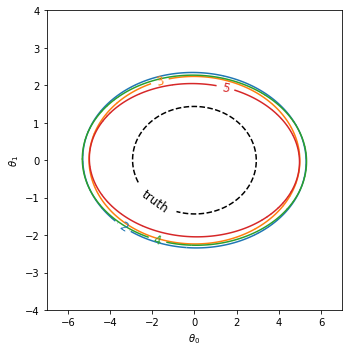

In [6]:
#Plot FisherInfo
fignn = plot_fisher_information_contours_2d(
    list_mean,
    list_error,
    colors=list_color,
    linestyles=list_style,
    inline_labels=list_label,
    xrange=(-7.,7.),
    yrange=(-4.,4.),
)